In [1]:
import pandas as pd
import datatable as dt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, precision_score, recall_score, roc_auc_score, make_scorer, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
import shap

import matplotlib.pyplot as plt

In [2]:
path_to_csv = r'/mnt/data/psteinmetz/neotex/CSV/TUMOUR.csv'
path_to_csv_ville = r'/mnt/data/psteinmetz/neotex/CSV/Tumour_ville.csv'
path_to_csv_ozgun = r'/mnt/data/psteinmetz/neotex/CSV/Tumour_testing2.csv'
path_to_csv_ozgun_target = r'/mnt/data/psteinmetz/neotex/CSV/Tumour_testing2.xlsx'

path_to_csv_bounding_box = r'/mnt/data/psteinmetz/neotex/CSV/BOUNDING_BOX.csv'
path_to_csv_ville_bounding_box = r'/mnt/data/psteinmetz/neotex/CSV/Bounding_box_ville.csv'
path_to_bounding_box_ozgun_csv = r'/mnt/data/psteinmetz/neotex/CSV/Bounding_box_testing2.csv'

In [3]:
data_train = pd.concat((dt.fread(path_to_csv).to_pandas(), dt.fread(path_to_csv_ville).to_pandas()), ignore_index=True)
data_eval = dt.fread(path_to_csv_ozgun).to_pandas()
target_eval = pd.read_excel(path_to_csv_ozgun_target, sheet_name='Sheet2')

data_bounding_box_train = pd.concat((dt.fread(path_to_csv_bounding_box).to_pandas(), dt.fread(path_to_csv_ville_bounding_box).to_pandas()), ignore_index=True).add_prefix('bb_')
data_bounding_box_eval = dt.fread(path_to_bounding_box_ozgun_csv).to_pandas().add_prefix('bb_')

In [4]:
original_radiomic_train_data = data_train.filter(regex='original')
original_radiomic_eval_data = data_eval.filter(regex='original')

original_radiomic_train_bb_data = data_bounding_box_train.filter(regex='original')
original_radiomic_eval_bb_data = data_bounding_box_eval.filter(regex='original')

In [5]:
originalT1_40_train_data = original_radiomic_train_data.filter(regex='40')
originalT1_train_data = original_radiomic_train_data[original_radiomic_train_data.columns.drop(list(original_radiomic_train_data.filter(regex='40|T2')))]
originalT1_bb_train_data = original_radiomic_train_bb_data[original_radiomic_train_bb_data.columns.drop(list(original_radiomic_train_bb_data.filter(regex='40|T2')))]

In [6]:
originalT1_40_eval_data = original_radiomic_eval_data.filter(regex='40')
originalT1_40_bb_eval_data = original_radiomic_eval_bb_data.filter(regex='40')

originalT1_eval_data = original_radiomic_eval_data[original_radiomic_eval_data.columns.drop(list(original_radiomic_eval_data.filter(regex='40|T2')))]
originalT1_bb_eval_data = original_radiomic_eval_bb_data[original_radiomic_eval_bb_data.columns.drop(list(original_radiomic_eval_bb_data.filter(regex='40|T2')))]

In [7]:
original_shape_features_train_data_T1 = originalT1_train_data.filter(regex='shape')
original_shape_features_train_data_T1_40 = originalT1_40_train_data.filter(regex='shape')
original_2nd_order_features_bb_train_data_T1 = originalT1_bb_train_data[originalT1_bb_train_data.columns.drop(list(originalT1_bb_eval_data.filter(regex='shape|firstorder')))]

original_shape_features_eval_data_T1 = originalT1_eval_data.filter(regex='shape')
original_shape_features_eval_data_T1_40 = originalT1_40_eval_data.filter(regex='shape')

original_2nd_order_features_bb_eval_data_T1 = originalT1_bb_eval_data[originalT1_bb_eval_data.columns.drop(list(originalT1_bb_eval_data.filter(regex='shape|firstorder')))]

In [8]:
T1_40_train_data = pd.concat((original_shape_features_train_data_T1_40, original_2nd_order_features_bb_train_data_T1), axis=1)
T1_train_data = pd.concat((original_shape_features_train_data_T1, original_2nd_order_features_bb_train_data_T1), axis=1)

T1_40_eval_data = pd.concat((original_shape_features_eval_data_T1_40, original_2nd_order_features_bb_eval_data_T1), axis=1)

In [9]:
T1_40_train_data.drop(['original_shape_VoxelVolume_40.0', 'original_shape_LeastAxisLength_40.0',
       'original_shape_MajorAxisLength_40.0',
       'original_shape_Maximum2DDiameterColumn_40.0',
       'original_shape_Maximum2DDiameterRow_40.0',
       'original_shape_Maximum2DDiameterSlice_40.0',
       'original_shape_Maximum3DDiameter_40.0',
       'original_shape_MeshVolume_40.0', 'original_shape_MinorAxisLength_40.0', 'original_shape_SurfaceArea_40.0'], axis=1, inplace=True)

T1_40_eval_data.drop(['original_shape_VoxelVolume_40.0', 'original_shape_LeastAxisLength_40.0',
       'original_shape_MajorAxisLength_40.0',
       'original_shape_Maximum2DDiameterColumn_40.0',
       'original_shape_Maximum2DDiameterRow_40.0',
       'original_shape_Maximum2DDiameterSlice_40.0',
       'original_shape_Maximum3DDiameter_40.0',
       'original_shape_MeshVolume_40.0', 'original_shape_MinorAxisLength_40.0', 'original_shape_SurfaceArea_40.0'], axis=1, inplace=True)

In [10]:
shape_target_train = data_train[['Shape.1']]
margins_target_train = data_train[['Margins (MR)']]
shape_target_eval = target_eval[['mr_mass_shp.factor']]
margins_target_eval = target_eval[['mr_mass_mrg.factor']]

In [11]:
margins_target_train.loc[margins_target_train['Margins (MR)']== 'Circunscribed'] = 'Circumscribed'


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
label_encoder = LabelEncoder()
margins_target_train['Margins (MR)']= label_encoder.fit_transform(margins_target_train['Margins (MR)']) 
margins_target_eval['mr_mass_mrg.factor']= label_encoder.transform(margins_target_eval['mr_mass_mrg.factor'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
margins_target_train.loc[margins_target_train['Margins (MR)']==1, 'Margins (MR)'] = 0
margins_target_train.loc[margins_target_train['Margins (MR)']==2, 'Margins (MR)'] = 1
margins_target_eval.loc[margins_target_eval['mr_mass_mrg.factor']==1, 'mr_mass_mrg.factor'] = 0
margins_target_eval.loc[margins_target_eval['mr_mass_mrg.factor']==2, 'mr_mass_mrg.factor'] = 1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
scaler_T1_40 = StandardScaler()
scaled_train_data_T1_40 = pd.DataFrame(scaler_T1_40.fit_transform(T1_40_train_data), columns=T1_40_train_data.columns)

In [15]:
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

In [16]:
# Extract and sort feature coefficients
def get_feature_coefs(regression_model, X):

    coef_dict = {}

    # Filter coefficients less than 0.01
    for coef, feat in zip(regression_model.coef_[0, :], X.columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef

    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

In [17]:
# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):

    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')

    return color_vals

 
# Visualize coefficients
def visualize_coefs(coef_dict):

    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)

    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')

    plt.show()

In [112]:
rs = 123

# Grid search hyperparameters for a logistic regression model

def grid_search_lr(X_train, y_train, kfolds):
    params_grid = {
            'class_weight': [{0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, {0:0.5, 1:0.5}],
            'penalty': ["l1", "l2"],
            
            'C': np.arange(0.1, 3, 0.1)
                    }

    lr_model = LogisticRegression(random_state=rs, max_iter=1000, solver="liblinear")
    grid_search = GridSearchCV(estimator = lr_model,
                               param_grid = params_grid,
                               scoring='f1',
                               
                               cv = kfolds.split(X_train, y_train), 
                               verbose = 1)

    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    return best_params, grid_search

 

# Grid search hyperparameters for a random forest model

def grid_search_rf(X_train, y_train, kfolds):

    params_grid = {
            'max_depth': [2, 5, 10, 15, 20],
            'n_estimators': [5, 50, 100, 150, 200],
            'min_samples_split': [2, 5, 10, 15, 20],
            'max_features' : ['sqrt', 'log2', None]#,
            #'class_weight': [None, {0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, {0:0.5, 1:0.5}]

    }

    rf_model = RandomForestClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator = rf_model,
                               param_grid = params_grid,
                               scoring='f1',
                               cv = kfolds.split(X_train, y_train),
                               n_jobs=50,
                               verbose=True)

    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    return best_params, grid_search

def grid_search_xgb(X_train, y_train, kfolds, sample_weight):

    params_grid = {
        'max_depth': range (2, 10, 1),
        'n_estimators': range(60, 220, 40),
        'learning_rate': [0.1, 0.01, 0.05]
    }

    boost_model = XGBClassifier(objective= 'binary:logistic',
                                nthread=4, 
                                scale_pos_weight = sample_weight,
                                random_state=rs)
    grid_search = GridSearchCV(estimator=boost_model,
                               param_grid=params_grid,
                               scoring = 'f1',
                               cv = kfolds.split(X_train, y_train),
                               n_jobs=50,
                               verbose=True)
    
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    return best_params, grid_search


    
def return_kfold_score(model, to_fit, target, metric, kfolds, name=None):
    if metric == 'youden_index':
        score = round((cross_val_score(model, to_fit, target, scoring=make_scorer(recall_score), cv=kfolds) + cross_val_score(model, to_fit, target, scoring=make_scorer(recall_score,pos_label=0), cv=kfolds) -1).mean(), 2)
        std = round((cross_val_score(model, to_fit, target, scoring=make_scorer(recall_score), cv=kfolds) + cross_val_score(model, to_fit, target, scoring=make_scorer(recall_score,pos_label=0), cv=kfolds) -1).std(), 2)
    else:
        score = round(cross_val_score(model, to_fit, target, scoring=metric, cv=kfolds).mean(), 2)
        std = round(cross_val_score(model, to_fit, target, scoring=metric, cv=kfolds).std(), 2)

    return score, std

In [77]:
best_params_logreg_T1_40, grid_search_logreg_T1_40 = grid_search_lr(scaled_train_data_T1_40, margins_target_train.values.ravel(), skf)

Fitting 5 folds for each of 348 candidates, totalling 1740 fits


In [78]:
grid_search_logreg_T1_40.best_score_

0.6131054131054132

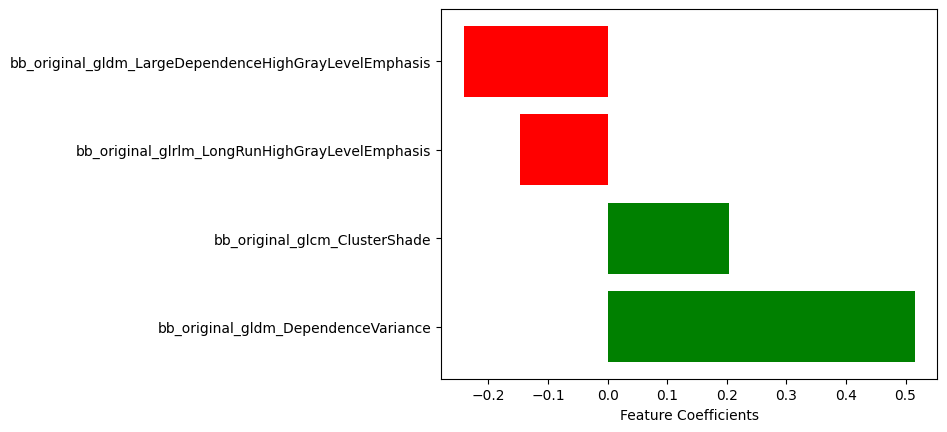

In [79]:
coef_dict = get_feature_coefs(grid_search_logreg_T1_40.best_estimator_, scaled_train_data_T1_40)
visualize_coefs(coef_dict)

In [80]:
background_values_T1_40 = shap.maskers.Independent(scaled_train_data_T1_40, max_samples=100)
# compute SHAP values
explainer_T1_40 = shap.Explainer(grid_search_logreg_T1_40.predict, background_values_T1_40)
shap_values_T1_40 = explainer_T1_40(scaled_train_data_T1_40)

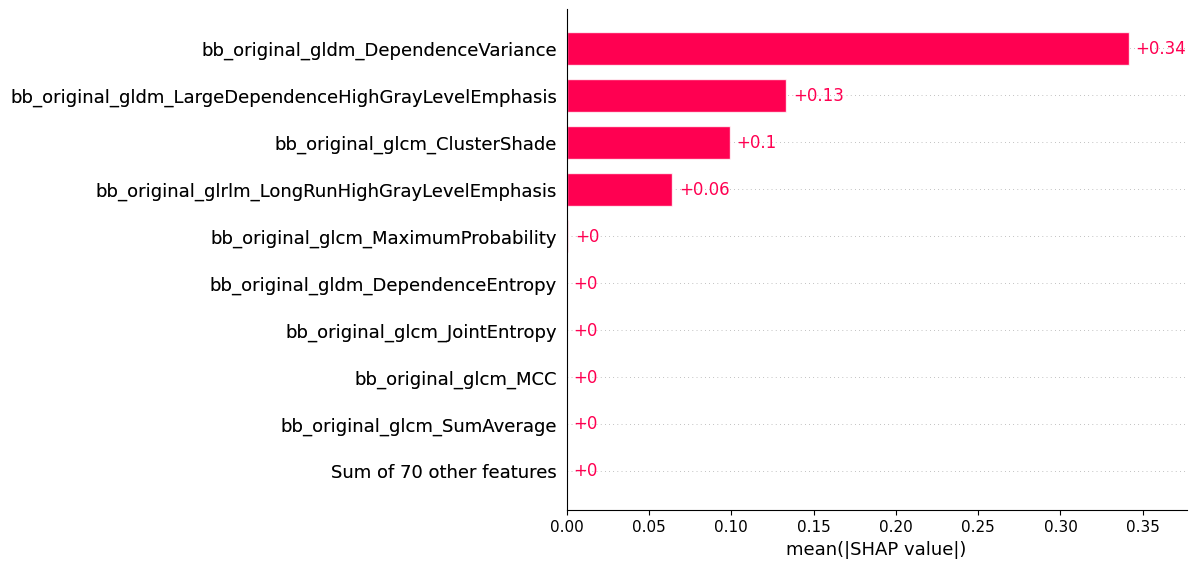

In [81]:
shap.plots.bar(shap_values_T1_40)

In [82]:
best_params_rf_T1_40, grid_search_randomforest_T1_40 = grid_search_rf(T1_40_train_data, margins_target_train.values.ravel(), skf)

Fitting 5 folds for each of 375 candidates, totalling 1875 fits


In [83]:
grid_search_randomforest_T1_40.best_params_

{'max_depth': 10,
 'max_features': None,
 'min_samples_split': 10,
 'n_estimators': 50}

Text(0.5, 1.0, 'Visualizing Feature Importances')

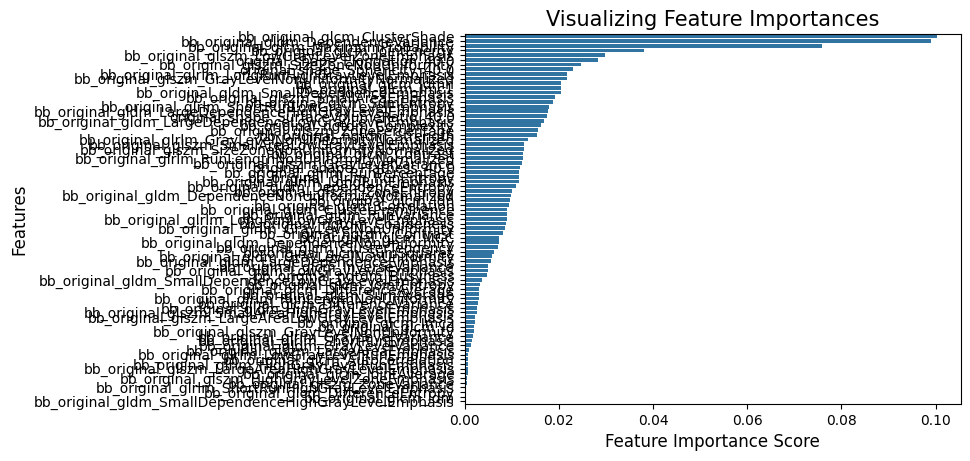

In [84]:
feature_imp = pd.Series(grid_search_randomforest_T1_40.best_estimator_.feature_importances_, index=T1_40_train_data.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Visualizing Feature Importances", fontsize=15)

In [85]:
feature_imp[:35]

bb_original_glcm_ClusterShade                            0.100320
bb_original_gldm_DependenceVariance                      0.098962
bb_original_glcm_MaximumProbability                      0.075959
bb_original_glcm_JointEnergy                             0.038184
bb_original_glszm_LowGrayLevelZoneEmphasis               0.029859
original_shape_Elongation_40.0                           0.028264
bb_original_glszm_SizeZoneNonUniformity                  0.024725
original_shape_Sphericity_40.0                           0.022993
bb_original_glrlm_LongRunHighGrayLevelEmphasis           0.021739
bb_original_glszm_GrayLevelNonUniformityNormalized       0.021718
bb_original_glcm_Idmn                                    0.020546
bb_original_glcm_Imc1                                    0.020515
bb_original_gldm_SmallDependenceEmphasis                 0.020413
bb_original_glszm_SmallAreaEmphasis                      0.019195
bb_original_glcm_SumEntropy                              0.018764
bb_origina

In [86]:
feature_imp

bb_original_glcm_ClusterShade                            0.100320
bb_original_gldm_DependenceVariance                      0.098962
bb_original_glcm_MaximumProbability                      0.075959
bb_original_glcm_JointEnergy                             0.038184
bb_original_glszm_LowGrayLevelZoneEmphasis               0.029859
                                                           ...   
bb_original_glszm_ZoneVariance                           0.000593
bb_original_glrlm_ShortRunHighGrayLevelEmphasis          0.000000
bb_original_glcm_DifferenceEntropy                       0.000000
bb_original_glcm_Idm                                     0.000000
bb_original_gldm_SmallDependenceHighGrayLevelEmphasis    0.000000
Length: 79, dtype: float64

In [87]:
feature_imp[:35].index

Index(['bb_original_glcm_ClusterShade', 'bb_original_gldm_DependenceVariance',
       'bb_original_glcm_MaximumProbability', 'bb_original_glcm_JointEnergy',
       'bb_original_glszm_LowGrayLevelZoneEmphasis',
       'original_shape_Elongation_40.0',
       'bb_original_glszm_SizeZoneNonUniformity',
       'original_shape_Sphericity_40.0',
       'bb_original_glrlm_LongRunHighGrayLevelEmphasis',
       'bb_original_glszm_GrayLevelNonUniformityNormalized',
       'bb_original_glcm_Idmn', 'bb_original_glcm_Imc1',
       'bb_original_gldm_SmallDependenceEmphasis',
       'bb_original_glszm_SmallAreaEmphasis', 'bb_original_glcm_SumEntropy',
       'bb_original_glrlm_ShortRunLowGrayLevelEmphasis',
       'bb_original_gldm_LargeDependenceHighGrayLevelEmphasis',
       'original_shape_SurfaceVolumeRatio_40.0',
       'bb_original_gldm_LargeDependenceLowGrayLevelEmphasis',
       'bb_original_ngtdm_Complexity', 'bb_original_glszm_ZonePercentage',
       'bb_original_ngtdm_Strength',
       'bb

In [88]:
restricted_nb_of_features_train = T1_40_train_data[feature_imp[:35].index]
restricted_nb_of_features_eval = T1_40_eval_data[feature_imp[:35].index]

In [89]:
restricted_best_params_rf_T1_40, restricted_grid_search_randomforest_T1_40 = grid_search_rf(restricted_nb_of_features_train, margins_target_train.values.ravel(), skf)

Fitting 5 folds for each of 375 candidates, totalling 1875 fits


In [90]:
background_values_T1_40 = shap.maskers.Independent(T1_40_train_data, max_samples=100)
# compute SHAP values
explainer_T1_40 = shap.Explainer(grid_search_randomforest_T1_40.predict, background_values_T1_40)
shap_values_T1_40 = explainer_T1_40(T1_40_train_data)

PermutationExplainer explainer: 137it [00:18,  3.36it/s]                         


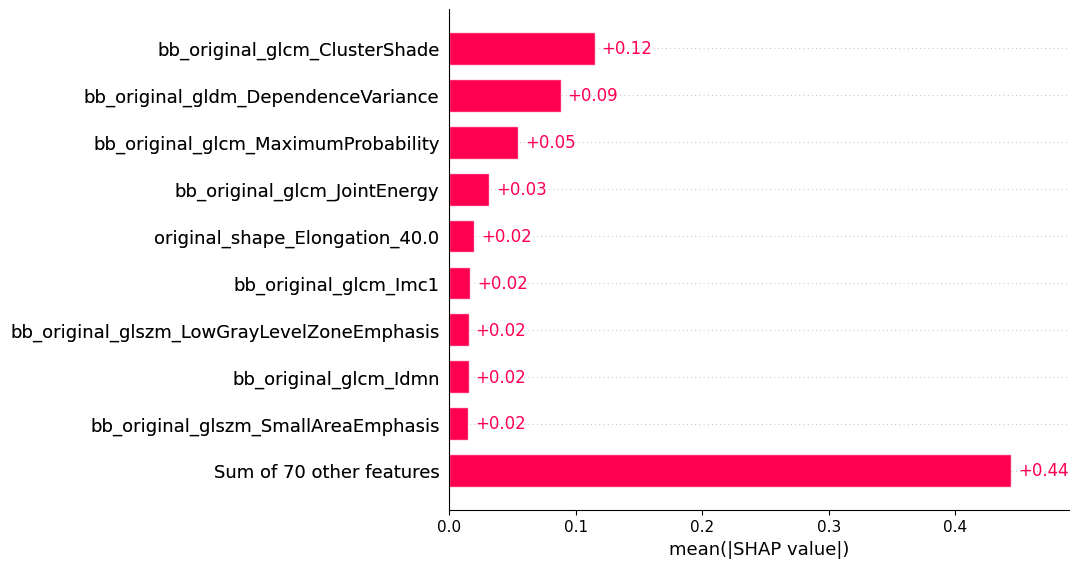

In [91]:
shap.plots.bar(shap_values_T1_40)

In [92]:
background_values_T1_40 = shap.maskers.Independent(restricted_nb_of_features_train, max_samples=100)
# compute SHAP values
explainer_T1_40 = shap.Explainer(restricted_grid_search_randomforest_T1_40.predict, background_values_T1_40)
shap_values_T1_40 = explainer_T1_40(restricted_nb_of_features_train)

PermutationExplainer explainer: 137it [00:35,  2.75it/s]                         


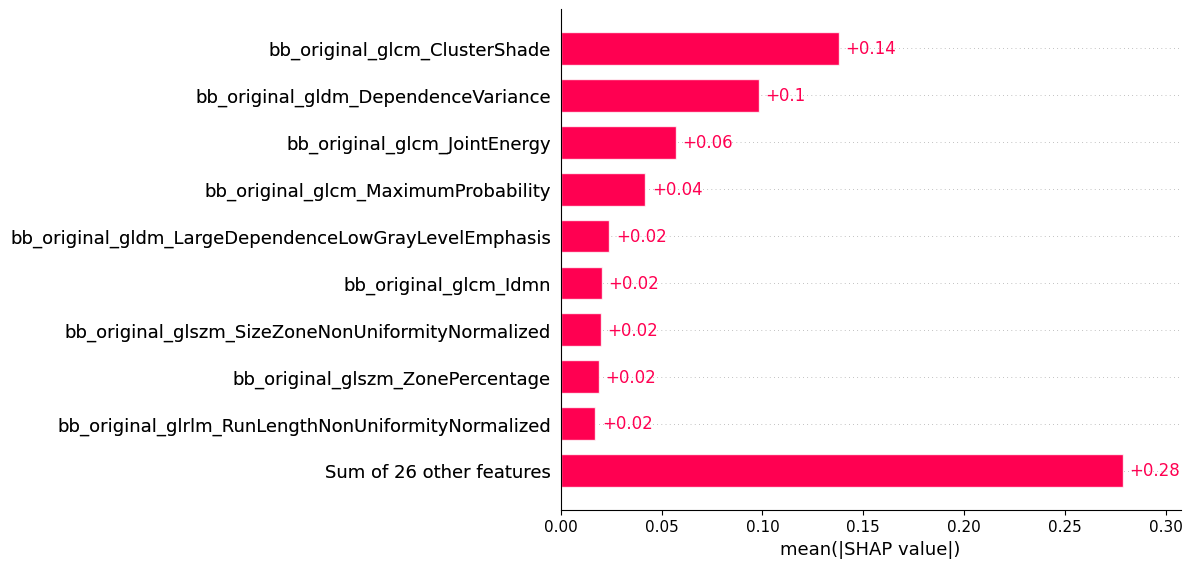

In [93]:
shap.plots.bar(shap_values_T1_40)

<Axes: >

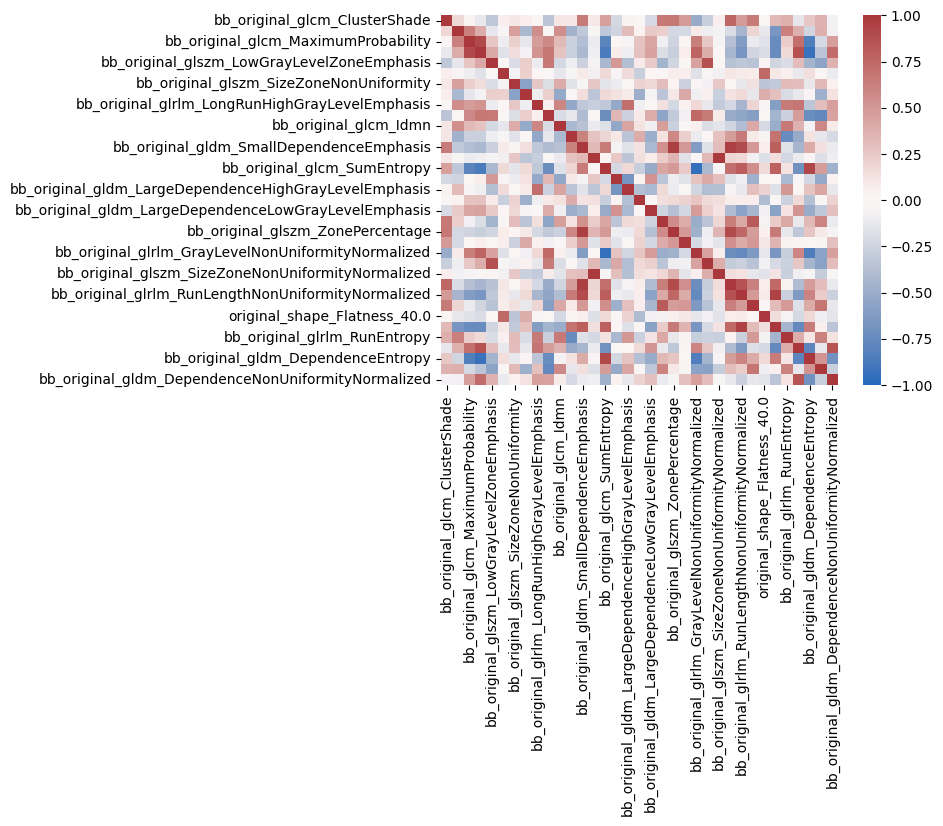

In [94]:
sns.heatmap(restricted_nb_of_features_train.corr(), cmap='vlag', vmin=-1, vmax=1)

In [95]:
ratio = float(margins_target_train.value_counts()[0]) / margins_target_train.value_counts()[1]

In [96]:
best_params_xgb_T1_40, grid_search_xgboost_T1_40 = grid_search_xgb(T1_40_train_data, margins_target_train.values.ravel(), skf, ratio)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [97]:
background_values_T1_40 = shap.maskers.Independent(T1_40_train_data, max_samples=100)
# compute SHAP values
explainer_T1_40 = shap.Explainer(grid_search_xgboost_T1_40.predict, background_values_T1_40)
shap_values_T1_40 = explainer_T1_40(T1_40_train_data)

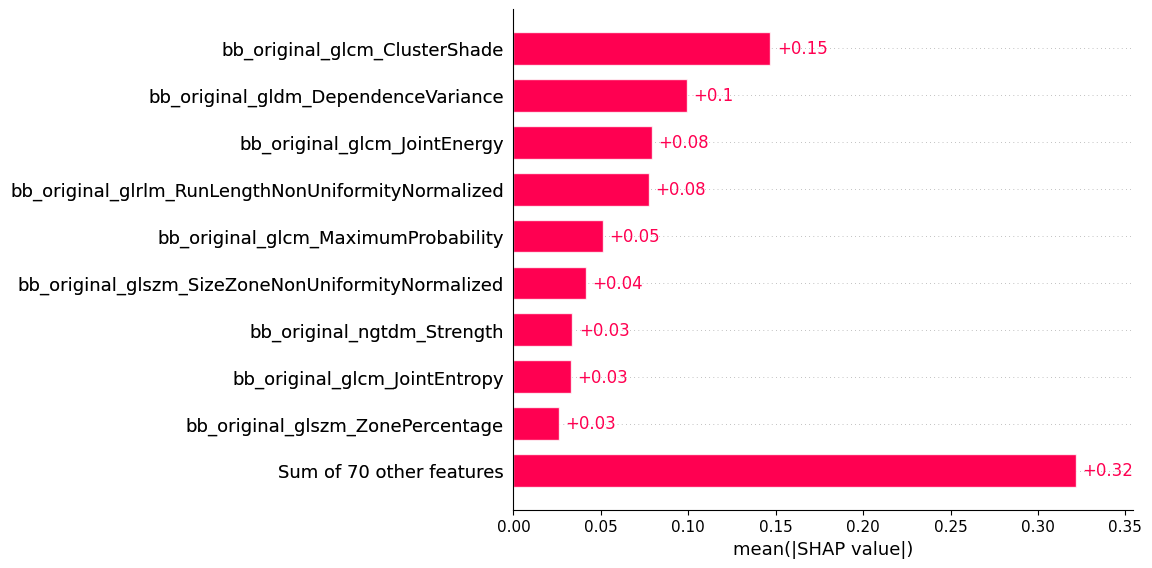

In [98]:
shap.plots.bar(shap_values_T1_40)

In [144]:
def compile_results(model, X, y, kfolds, return_bool=None):
    auc, auc_std = return_kfold_score(model, X, y, 'roc_auc', kfolds)
    balanced_accuracy, balanced_accuracy_std = return_kfold_score(model, X, y, 'balanced_accuracy', kfolds)
    precision, precision_std = return_kfold_score(model, X, y, 'precision', kfolds)
    recall, recall_std = return_kfold_score(model, X, y, 'recall', kfolds)
    f1, f1_std = return_kfold_score(model, X, y, 'f1', kfolds)

    scoring = {
        'sensitivity': make_scorer(recall_score),
        'specificity': make_scorer(recall_score,pos_label=0)
    }
    specificity, specificity_std = return_kfold_score(model, X, y, scoring['specificity'], kfolds, 'specificity')
    sensitivity, sensitivity_std = return_kfold_score(model, X, y, scoring['sensitivity'], kfolds, 'sensitivity')
    youden_index , youden_index_std = return_kfold_score(model, X, y, 'youden_index', kfolds, 'youden_index')

    if return_bool is None:
        for x in [('auc', auc, auc_std), ('balanced_acc', balanced_accuracy, balanced_accuracy_std), ('precision', precision, precision_std), ('recall', recall, recall_std), ('f1', f1, f1_std), ('specificity', specificity, specificity_std), ('sensitivity', sensitivity, sensitivity_std), ('youden_index', youden_index, youden_index_std)]:       
            print(str(x[0]) + ' ' + str(str(x[1])) + ' +/- ' + str(x[2]))

    if return_bool:

        return [(auc, auc_std), (balanced_accuracy, balanced_accuracy_std), (precision, precision_std), (recall, recall_std), (f1, f1_std), (specificity, specificity_std), (sensitivity, sensitivity_std), (youden_index, youden_index_std)]

In [139]:
comp_results = [compile_results(x, scaled_train_data_T1_40, margins_target_train.values.ravel(), skf, True) for x in [grid_search_logreg_T1_40.best_estimator_, grid_search_randomforest_T1_40.best_estimator_, grid_search_xgboost_T1_40.best_estimator_]]
results = pd.DataFrame(comp_results, index=['Logistic Regression', 'Random Forest', 'XG Boost'], columns=['auc', 'balanced_accuracy', 'precision', 'recall', 'f1', 'specificity', 'sensitivity', 'youden_index']).T

In [140]:
results

,Logistic Regression,Random Forest,XG Boost
auc,"(0.69, 0.1)","(0.64, 0.12)","(0.67, 0.08)"
balanced_accuracy,"(0.65, 0.09)","(0.63, 0.11)","(0.64, 0.1)"
precision,"(0.62, 0.14)","(0.6, 0.14)","(0.61, 0.14)"
recall,"(0.65, 0.16)","(0.6, 0.13)","(0.6, 0.14)"
f1,"(0.61, 0.1)","(0.59, 0.11)","(0.59, 0.1)"
specificity,"(0.66, 0.16)","(0.67, 0.15)","(0.68, 0.16)"
sensitivity,"(0.65, 0.16)","(0.6, 0.13)","(0.6, 0.14)"
youden_index,"(0.31, 0.18)","(0.27, 0.22)","(0.27, 0.2)"


In [145]:
print('Random Forest_T1_40')
compile_results(restricted_grid_search_randomforest_T1_40.best_estimator_, restricted_nb_of_features_train, margins_target_train.values.ravel(), skf)

Random Forest_T1_40
auc 0.67 +/- 0.1
balanced_acc 0.66 +/- 0.11
precision 0.67 +/- 0.2
recall 0.6 +/- 0.13
f1 0.61 +/- 0.11
specificity 0.72 +/- 0.18
sensitivity 0.6 +/- 0.13
youden_index 0.32 +/- 0.23


In [74]:
def compute_pred(model, X_test):
    return model.predict(X_test)

LogisticRegression(C=0.4, class_weight={0: 0.4, 1: 0.6}, max_iter=1000,
                   penalty='l1', random_state=123, solver='liblinear')
sensitivity: 0.631578947368421
specificity: 0.5483870967741935
youden_index: 0.17996604414261452
balanced_accuracy: 0.5899830220713073
roc_auc: 0.5899830220713073
precision: 0.46153846153846156
recall: 0.631578947368421
              precision    recall  f1-score   support

           0       0.71      0.55      0.62        31
           1       0.46      0.63      0.53        19

    accuracy                           0.58        50
   macro avg       0.58      0.59      0.58        50
weighted avg       0.61      0.58      0.59        50

RandomForestClassifier(max_depth=10, max_features=None, min_samples_split=10,
                       n_estimators=50, random_state=123)
sensitivity: 0.7894736842105263
specificity: 0.6129032258064516
youden_index: 0.40237691001697806
balanced_accuracy: 0.701188455008489
roc_auc: 0.701188455008489
precision: 0

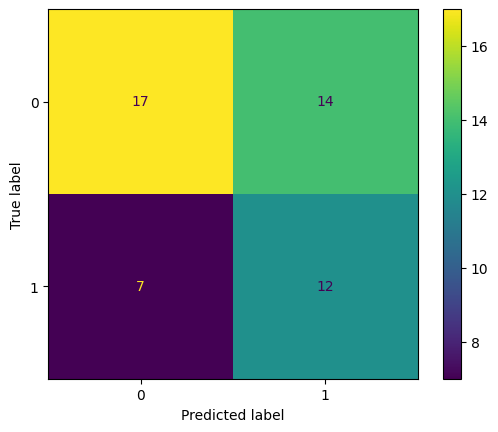

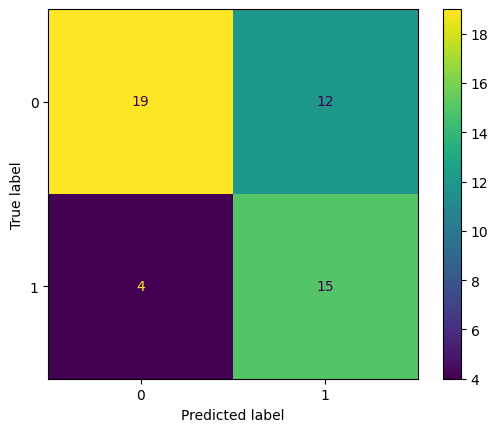

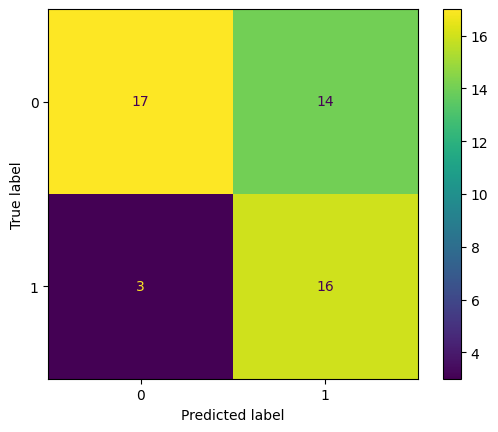

In [75]:
for model in [grid_search_logreg_T1_40.best_estimator_, grid_search_randomforest_T1_40.best_estimator_, grid_search_xgboost_T1_40.best_estimator_]:
    scoring = {
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'precision_recall_f': make_scorer(precision_recall_fscore_support)
    }
    if model == grid_search_logreg_T1_40.best_estimator_:
        scaled_eval_features = pd.DataFrame(scaler_T1_40.transform(T1_40_eval_data), columns=T1_40_eval_data.columns)
        y_pred = compute_pred(model, scaled_eval_features)
        print(model)
        print('sensitivity: ' + str(scoring['sensitivity'](model, scaled_eval_features, margins_target_eval)))
        print('specificity: ' + str(scoring['specificity'](model, scaled_eval_features, margins_target_eval)))
        print('youden_index: ' + str(scoring['specificity'](model, scaled_eval_features, margins_target_eval)+ scoring['sensitivity'](model, scaled_eval_features, margins_target_eval) - 1))
        print('balanced_accuracy: ' + str(scoring['balanced_accuracy'](model, scaled_eval_features, margins_target_eval)))
        print('roc_auc: ' + str(scoring['roc_auc'](model, scaled_eval_features, margins_target_eval)))
        print('precision: ' + str(scoring['precision'](model, scaled_eval_features, margins_target_eval)))
        print('recall: ' + str(scoring['recall'](model, scaled_eval_features, margins_target_eval)))
        
    else:
        y_pred = compute_pred(model, T1_40_eval_data)
        print(model)
        print('sensitivity: ' + str(scoring['sensitivity'](model, T1_40_eval_data, margins_target_eval)))
        print('specificity: ' + str(scoring['specificity'](model, T1_40_eval_data, margins_target_eval)))
        print('youden_index: ' + str(scoring['specificity'](model, T1_40_eval_data, margins_target_eval)+ scoring['sensitivity'](model, T1_40_eval_data, margins_target_eval) - 1))
        print('balanced_accuracy: ' + str(scoring['balanced_accuracy'](model, T1_40_eval_data, margins_target_eval)))
        print('roc_auc: ' + str(scoring['roc_auc'](model, T1_40_eval_data, margins_target_eval)))
        print('precision: ' + str(scoring['precision'](model, T1_40_eval_data, margins_target_eval)))
        print('recall: ' + str(scoring['recall'](model, T1_40_eval_data, margins_target_eval)))

    print(classification_report(margins_target_eval.values.ravel(), y_pred))
    cm = confusion_matrix(margins_target_eval.values.ravel(), y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    disp.plot()
    

RandomForestClassifier(max_depth=5, max_features=None, min_samples_split=10,
                       random_state=123)
sensitivity: 0.8421052631578947
specificity: 0.6129032258064516
youden_index: 0.4550084889643462
balanced_accuracy: 0.7275042444821731
roc_auc: 0.7275042444821731
precision: 0.5714285714285714
recall: 0.8421052631578947
              precision    recall  f1-score   support

           0       0.86      0.61      0.72        31
           1       0.57      0.84      0.68        19

    accuracy                           0.70        50
   macro avg       0.72      0.73      0.70        50
weighted avg       0.75      0.70      0.70        50



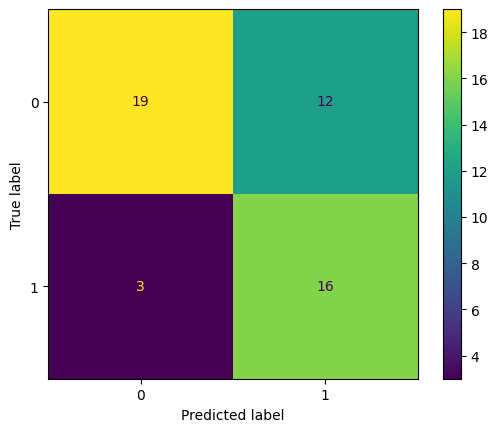

In [47]:
for model in [restricted_grid_search_randomforest_T1_40.best_estimator_]:
    scoring = {
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'precision_recall_f': make_scorer(precision_recall_fscore_support)
    }
    if model == grid_search_logreg_T1_40.best_estimator_:
        scaled_eval_features = pd.DataFrame(scaler_T1_40.transform(T1_40_eval_data), columns=T1_40_eval_data.columns)
        y_pred = compute_pred(model, scaled_eval_features)
        print(model)
        print('sensitivity: ' + str(scoring['sensitivity'](model, scaled_eval_features, margins_target_eval)))
        print('specificity: ' + str(scoring['specificity'](model, scaled_eval_features, margins_target_eval)))
        print('youden_index: ' + str(scoring['specificity'](model, scaled_eval_features, margins_target_eval)+ scoring['sensitivity'](model, scaled_eval_features, margins_target_eval) - 1))
        print('balanced_accuracy: ' + str(scoring['balanced_accuracy'](model, scaled_eval_features, margins_target_eval)))
        print('roc_auc: ' + str(scoring['roc_auc'](model, scaled_eval_features, margins_target_eval)))
        print('precision: ' + str(scoring['precision'](model, scaled_eval_features, margins_target_eval)))
        print('recall: ' + str(scoring['recall'](model, scaled_eval_features, margins_target_eval)))
        
    else:
        y_pred = compute_pred(model, restricted_nb_of_features_eval)
        print(model)
        print('sensitivity: ' + str(scoring['sensitivity'](model, restricted_nb_of_features_eval, margins_target_eval)))
        print('specificity: ' + str(scoring['specificity'](model, restricted_nb_of_features_eval, margins_target_eval)))
        print('youden_index: ' + str(scoring['specificity'](model, restricted_nb_of_features_eval, margins_target_eval)+ scoring['sensitivity'](model, restricted_nb_of_features_eval, margins_target_eval) - 1))
        print('balanced_accuracy: ' + str(scoring['balanced_accuracy'](model, restricted_nb_of_features_eval, margins_target_eval)))
        print('roc_auc: ' + str(scoring['roc_auc'](model, restricted_nb_of_features_eval, margins_target_eval)))
        print('precision: ' + str(scoring['precision'](model, restricted_nb_of_features_eval, margins_target_eval)))
        print('recall: ' + str(scoring['recall'](model, restricted_nb_of_features_eval, margins_target_eval)))

    print(classification_report(margins_target_eval.values.ravel(), y_pred))
    cm = confusion_matrix(margins_target_eval.values.ravel(), y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    disp.plot()
    